<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embeddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará el guión de Starwars Episodio IV.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

In [2]:
from google.colab import files
import io 


### Datos
Utilizaremos como dataset el guión de Star Wars, episodio 4.

In [3]:
 uploaded = files.upload()

Saving episode_IV.txt to episode_IV.txt


In [4]:
df = pd.read_csv(io.BytesIO(uploaded['episode_IV.txt']), sep=" ", header=None)

In [5]:
df.head(10)

,0,1,2
0,0,character,dialogue
1,1,THREEPIO,Did you hear that? They've shut down the main...
2,2,THREEPIO,We're doomed!
3,3,THREEPIO,There'll be no escape for the Princess this time.
4,4,THREEPIO,What's that?
5,5,THREEPIO,I should have known better than to trust the l...
6,6,LUKE,Hurry up! Come with me! What are you waiting...
7,7,THREEPIO,"Artoo! Artoo-Detoo, where are you?"
8,8,THREEPIO,At last! Where have you been?
9,9,THREEPIO,They're heading in this direction. What are we...


In [6]:
df.size/3

1011.0

In [7]:
df.columns = ["0", "character", "dialogue"]

In [8]:
df = df.tail(1010)

In [9]:
df.head(5)

,0,character,dialogue
1,1,THREEPIO,Did you hear that? They've shut down the main...
2,2,THREEPIO,We're doomed!
3,3,THREEPIO,There'll be no escape for the Princess this time.
4,4,THREEPIO,What's that?
5,5,THREEPIO,I should have known better than to trust the l...


In [10]:
df = df.drop(columns=["0", "character"])

In [11]:
type(df)

pandas.core.frame.DataFrame

### 1 - Preprocesamiento

In [12]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [13]:
# Demos un vistazo
sentence_tokens[:4]

[['did',
  'you',
  'hear',
  'that',
  "they've",
  'shut',
  'down',
  'the',
  'main',
  'reactor',
  "we'll",
  'be',
  'destroyed',
  'for',
  'sure',
  'this',
  'is',
  'madness'],
 ["we're", 'doomed'],
 ["there'll", 'be', 'no', 'escape', 'for', 'the', 'princess', 'this', 'time'],
 ["what's", 'that']]

### 2 - Crear los vectores (word2vec)

In [14]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [15]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     #size=20,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram


                     #me estaba dando un error haciendo referencia a que no reconocía la variable size, al comentarla funcionó bien

In [16]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [17]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 1010


In [18]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 378


### 3 - Entrenar el modelo generador

In [19]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 114314.15625
Loss after epoch 1: 56943.015625
Loss after epoch 2: 56050.0
Loss after epoch 3: 55427.984375
Loss after epoch 4: 55697.40625
Loss after epoch 5: 55845.09375
Loss after epoch 6: 54771.71875
Loss after epoch 7: 54891.4375
Loss after epoch 8: 55574.375
Loss after epoch 9: 56457.8125
Loss after epoch 10: 56860.5625
Loss after epoch 11: 56171.6875
Loss after epoch 12: 56813.5625
Loss after epoch 13: 55770.0625
Loss after epoch 14: 57354.5625
Loss after epoch 15: 56409.6875
Loss after epoch 16: 55853.1875
Loss after epoch 17: 54249.0625
Loss after epoch 18: 48477.125
Loss after epoch 19: 48805.375


(116649, 226680)

### 4 - Ensayar

In [20]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["jedi"], topn=10)

[('computer', 0.9958130717277527),
 ('same', 0.9957606792449951),
 ('set', 0.9953656196594238),
 ('control', 0.9952285289764404),
 ('senate', 0.9952104091644287),
 ('open', 0.9951055645942688),
 ('until', 0.9950763583183289),
 ('plans', 0.9950366616249084),
 ('ships', 0.9950223565101624),
 ('full', 0.9948698282241821)]

In [21]:
w2v_model.wv.most_similar(positive=["kenobi"], topn=10)

[('obi', 0.9876440167427063),
 ('ben', 0.9526587724685669),
 ('wan', 0.9382275342941284),
 ('help', 0.9281784296035767),
 ('old', 0.9244764447212219),
 ('me', 0.8744224905967712),
 ('hope', 0.8717252612113953),
 ('only', 0.8486301898956299),
 ("you're", 0.7988994121551514),
 ('says', 0.7918076515197754)]

In [ ]:
w2v_model.wv.most_similar(positive=["empire"], topn=10)

[('control', 0.9953052997589111),
 ('made', 0.9949855208396912),
 ('part', 0.9947618842124939),
 ('aboard', 0.994728147983551),
 ('academy', 0.9944762587547302),
 ('jump', 0.9944255948066711),
 ('open', 0.9942321181297302),
 ('information', 0.9941219687461853),
 ('senate', 0.9940589070320129),
 ('destroy', 0.9940364956855774)]

In [ ]:
w2v_model.wv.most_similar(positive=["vader"], topn=10)

[('until', 0.9923199415206909),
 ('destroy', 0.9911565184593201),
 ('which', 0.9906333088874817),
 ('their', 0.990632176399231),
 ('its', 0.9906201958656311),
 ('keep', 0.9904095530509949),
 ('set', 0.9903144836425781),
 ('against', 0.9902732968330383),
 ('whole', 0.9902541637420654),
 ('first', 0.990050733089447)]

In [ ]:
w2v_model.wv.most_similar(positive=["threepio"], topn=10)

[('come', 0.9653793573379517),
 ('where', 0.9564709067344666),
 ('see', 0.952019989490509),
 ('artoo', 0.9491345882415771),
 ('with', 0.9458937644958496),
 ('could', 0.9446573853492737),
 ('why', 0.9426396489143372),
 ('they', 0.9399495124816895),
 ('give', 0.9397366046905518),
 ('let', 0.939728319644928)]

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["vader"], topn=10)

[('wan', -0.5989100933074951),
 ('kenobi', -0.6000456809997559),
 ('obi', -0.6040414571762085),
 ('ben', -0.7709953784942627),
 ('help', -0.7966666221618652),
 ('old', -0.824530839920044),
 ('i', -0.8572590947151184),
 ('red', -0.8598333597183228),
 ('me', -0.8615196347236633),
 ('know', -0.8671163320541382)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["chewie"], topn=10)

[('negative', 0.996924877166748),
 ('gone', 0.9966174364089966),
 ('wedge', 0.9958494901657104),
 ('yeah', 0.9956520795822144),
 ('myself', 0.9955992698669434),
 ('believe', 0.9955276250839233),
 ('forget', 0.9955263733863831),
 ('thank', 0.9955089092254639),
 ('trust', 0.9954884052276611),
 ('leave', 0.9954570531845093)]

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["chewie"], topn=10)

[('wan', -0.6753507256507874),
 ('kenobi', -0.6800461411476135),
 ('obi', -0.6810280680656433),
 ('ben', -0.8358489274978638),
 ('red', -0.8608366847038269),
 ('help', -0.863762378692627),
 ('old', -0.8732428550720215),
 ('station', -0.8842846751213074),
 ('standing', -0.8849408626556396),
 ('i', -0.8956842422485352)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["star"], topn=10)

[('systems', 0.9933107495307922),
 ('range', 0.9903370141983032),
 ('death', 0.9903028011322021),
 ('fire', 0.9899194836616516),
 ('system', 0.9895832538604736),
 ('main', 0.9895464181900024),
 ('into', 0.9892478585243225),
 ('planet', 0.9891698360443115),
 ('attack', 0.9887900948524475),
 ('power', 0.9884552955627441)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["death"], topn=10)

[('next', 0.9953973889350891),
 ('made', 0.9953623414039612),
 ('system', 0.995306134223938),
 ('destroy', 0.995083212852478),
 ('its', 0.995045006275177),
 ('control', 0.994960367679596),
 ('open', 0.9948273301124573),
 ('range', 0.9947956800460815),
 ('systems', 0.994743824005127),
 ('whole', 0.9945952892303467)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["luke"], topn=10)

[('pull', 0.9891158938407898),
 ('hurry', 0.9886924624443054),
 ('easy', 0.9884053468704224),
 ("you'll", 0.9877944588661194),
 ('trying', 0.9874411821365356),
 ('done', 0.9872480034828186),
 ('wedge', 0.9872284531593323),
 ('fighters', 0.987207293510437),
 ('give', 0.9871931076049805),
 ('always', 0.987103283405304)]

### 5 - Visualizar agrupación de vectores

In [22]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model):
    num_dimensions = 2  

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [25]:
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


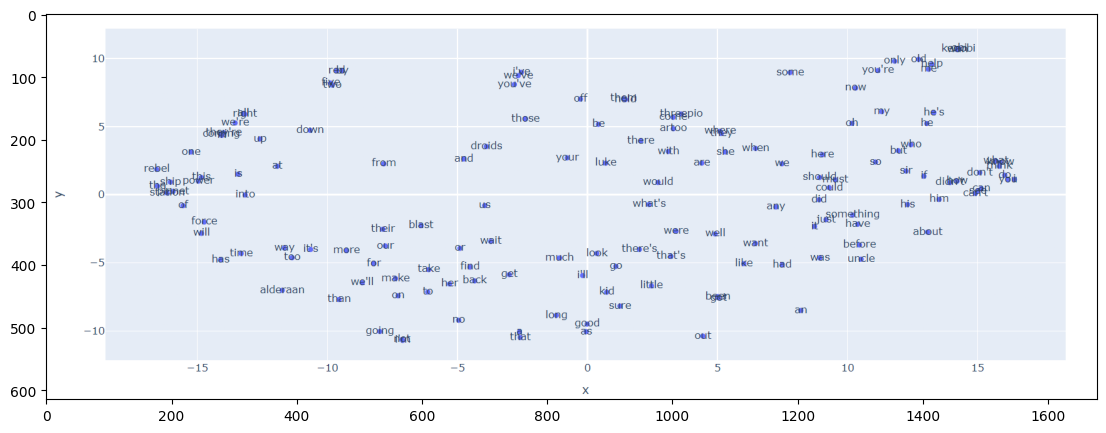

In [32]:

img = mpimg.imread('embedding 3.png')
imgplot = plt.imshow(img)
plt.rcParams["figure.figsize"] = [10,5]
plt.show()

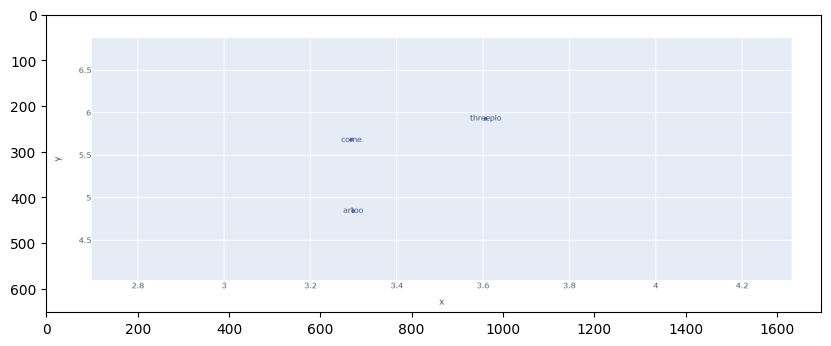

In [34]:
img = mpimg.imread('embedding 1 .png')
imgplot = plt.imshow(img)
plt.rcParams["figure.figsize"] = [10,5]
plt.show()

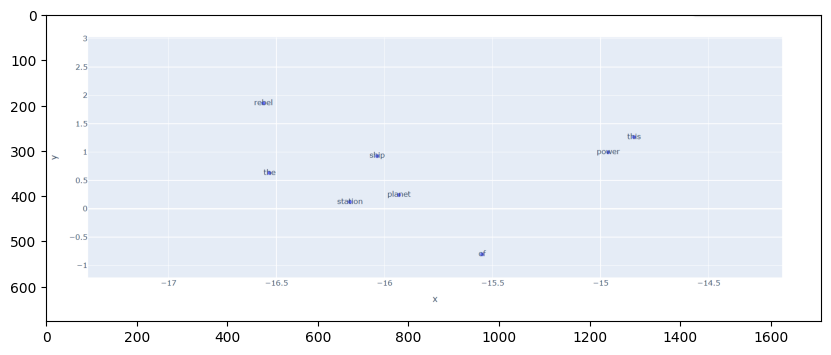

In [35]:
img = mpimg.imread('embedding 2 .png')
imgplot = plt.imshow(img)
plt.rcParams["figure.figsize"] = [10,5]
plt.show()

### Alumno

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

Conclusiones:

Los resultados serían mejores en caso de dedicarle mas al preprocesamiento (lemmatization, stop words removal), así perderían relevancia muchos tokens genéricos sin sentido específico.
Editando los parámetros de la función que detalla al embedding (Word2Vec) podemos mejorar el modelo, a cambio de tener un entrenamiento mas pesado. Por otro lado también, se puede aumentar los epochs del entramiento para mejorar el desempeño de modelo.

En los Zoom-In dentro del gráfico de embeddings se obtiene coherencia entre los conceptos y sus distancia